In [20]:
from meteostat import Stations
import pandas as pd

In [16]:


# Retrieve all Meteostat weather stations
stations = Stations()

# Fetch the list of all stations
all_stations = stations.fetch()

# Convert the result to a DataFrame
df_stations = all_stations[['name', 'latitude', 'longitude', 'elevation', 'country']]




In [17]:
df_stations.shape

(15791, 5)

In [18]:
df_stations.head()

,name,latitude,longitude,elevation,country
id,,,,,
00FAY,Holden Agdm,53.1900,-112.2500,688.0,CA
00TG6,Athabasca 1,54.7200,-113.2900,515.0,CA
01001,Jan Mayen,70.9333,-8.6667,10.0,NO
01002,Grahuken,79.7833,14.4667,0.0,NO
01003,Hornsund,77.0000,15.5000,10.0,NO


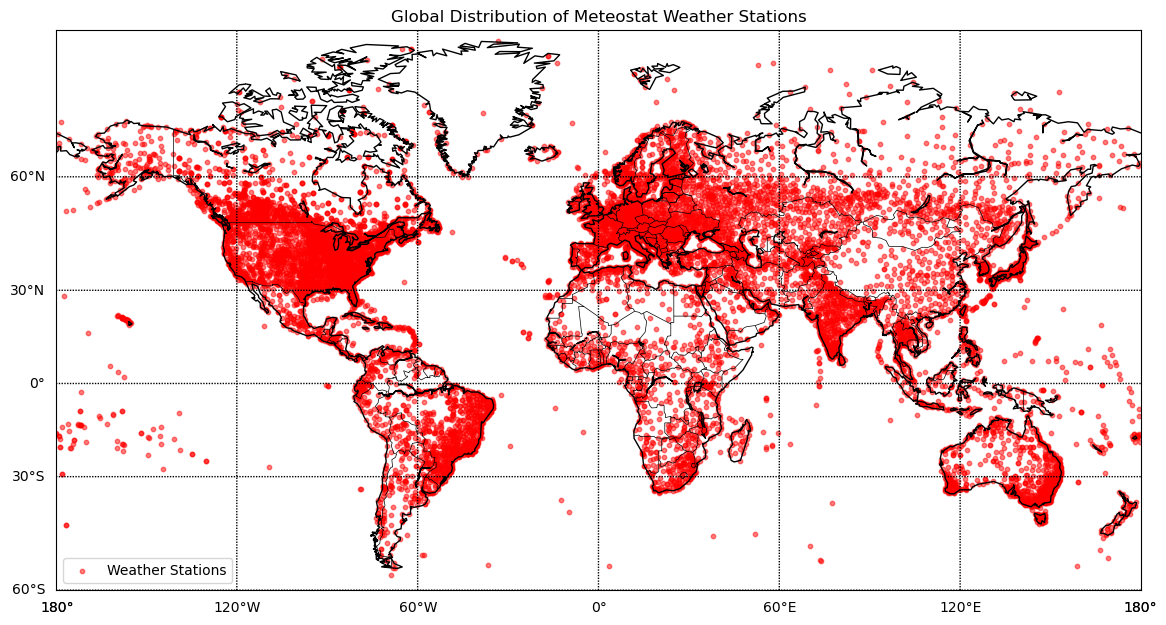

In [19]:
from meteostat import Stations
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

# Create the Basemap figure
plt.figure(figsize=(14, 8))
m = Basemap(projection='mill', llcrnrlat=-60, urcrnrlat=85, llcrnrlon=-180, urcrnrlon=180, resolution='c')

# Draw map details
m.drawcoastlines()
m.drawcountries()
m.drawparallels(range(-90, 91, 30), labels=[1, 0, 0, 0])
m.drawmeridians(range(-180, 181, 60), labels=[0, 0, 0, 1])

# Extract latitude and longitude from the DataFrame
lats = df_stations['latitude'].values
lons = df_stations['longitude'].values

# Convert latitude and longitude to map projection coordinates
x, y = m(lons, lats)

# Plot the stations as red dots
m.scatter(x, y, s=10, color='red', alpha=0.5, marker='o', label='Weather Stations')

# Add a legend and title
plt.legend(loc='lower left')
plt.title('Global Distribution of Meteostat Weather Stations')

# Show the plot
plt.show()